In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/LDA"
os.chdir(path)

In [ ]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint

In [ ]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import  simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

df = pd.read_csv('stopwords-EV.csv') 
add_lst = [w.lower() for w in df['stopwords'].values]
stop_words.extend(add_lst)

stop_words.extend(['energy'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


In [ ]:
!pip install langdetect
!pip install fuzzywuzzy
!pip install pyecharts
!pip install joypy
!pip install apyori
!pip install yake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 13.4 MB/s 


# 1. 数据载入

In [ ]:
import pickle

with open('data_ready_0507_ori_no_energy_en.pickle', 'rb') as handle:
    data_ready = pickle.load(handle)

In [ ]:
import pickle

with open('df_abstract_0507_no_energy_en.pickle', 'rb') as handle:
    df_abstract = pickle.load(handle)
    df_abstract = df_abstract.reset_index(drop=True)

In [ ]:
def labelcite1(cite):
  try:
      if int(cite) > 300:
          return '1'
      elif int(cite) > 200:
          return '2'
      elif int(cite) > 150:
          return '3'
      elif int(cite) > 120:
          return '4'
      elif int(cite) > 100:
          return '5'
      elif int(cite) > 50:
          return '6'
      elif int(cite) > 0:
          return '7'
      else:
          return '0'
  except:
      return '0'

def modify_citation(cite):
    if int(cite) > 10000:
        return 10000
    else:
        return int(cite)
df_abstract["cite_label"] = df_abstract['cite'].apply(labelcite1)
df_abstract["cite"] = df_abstract['cite'].apply(modify_citation)

# reverse_cite_map = ['no value', '>300', '>200', '>150', '>120', '>100', '>50', '>0']
reverse_cite_map = ['no value', '>300', '>200', '>150', '>120', '>100', '>50', '>0']

### 1. citation分析

1. citation分布
[饼图](https://echarts.apache.org/examples/zh/editor.html?c=pie-borderRadius&code=PYBwLglsB2AEC8sDeAoWszGAG0iAXMmuhgE4QDmFApqYQOQRjUC29xAvgDTHbU3QAJoVQkMoBgFYApPR5i-AMzAMAxtWjNS7dN2IBnWhGr7CAbWLpRY2NACGLagwCCq9fv2wAYqWBt5NmAAniBOsPQgxnKWJKR2ghAArqawZvQALAAMslzhAOzZ9AC6AWJ2AG7AEIIAMnYARtTYAPLltNh2BLCKdtiGpSRMrADKwXwiMWL1wKSCtABK8UkpAIyZA1Mzc6QAwjgzDADEiifRNiTTs7QA6tVgABaEAEyTsHrnHY3YE-fo-vfAADuhB6fWoGxIIGA-iYUGgag0Wh0NneNlYIHudhhKWsHwaTR-vz-AOBZES4NeYkUMDAwwgAC8whlMmcid0addqJR7ipwtNsIJkecOK9UQp8dgahBoGFcTZ_kCQb1DKKIYI7GA7OZKchyr1yYQABx5Q25eyOBgAPgAzJkWXokHrsAbYAV1rYHEzLU87fQHU6XQVrWbPVaVpJ7TxHfqwnlrZIQxbwpaVj6_VGA7HrcGPUn6Cnff6Y4RrXkComvRH0yho86wtbDZJ0gA2CtW-2vIoxEXoLscADcQA)

In [ ]:
df = df_abstract['cite_label'].value_counts().to_frame()
df['count'] = df.cite_label
df['cite_label'] = df.index
df = df.sort_values("cite_label")

for idx, row in df.iterrows():
    print("{" + f"value: {row['count']}, name: '{reverse_cite_map[int(row['cite_label'])]}'" + "},")

{value: 878, name: '>300'},
{value: 700, name: '>200'},
{value: 703, name: '>150'},
{value: 735, name: '>120'},
{value: 733, name: '>100'},
{value: 3770, name: '>50'},
{value: 38546, name: '>0'},


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  del sys.path[0]


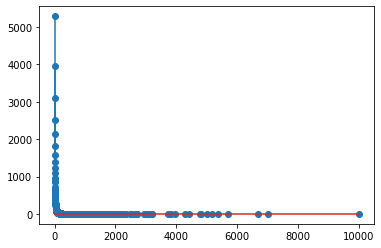

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df = df_abstract['cite'].value_counts().to_frame()
df['count'] = df.cite
df['cite'] = df.index
df['cite'] = df['cite'].astype(int)
df = df.sort_values("cite")

x = df['cite'].values
y = df['count'].values

plt.stem(x, y)
plt.show()

2. 不同档次citation随时间的变化

In [ ]:
df = df_abstract[['submit_time', 'cite_label']].copy()
cite_year = np.zeros((len(reverse_cite_map), 13))
for i, year in enumerate(range(2010, 2023)):
    df1 = df[df['submit_time'] == year]
    df2 = df1['cite_label'].value_counts().to_frame()
    df2['count'] = df2.cite_label
    df2['cite_label'] = df2.index
    df2 = df2.sort_values("cite_label")
    col = np.zeros(len(reverse_cite_map))
    for id, row in df2.iterrows():
        col[int(row['cite_label'])] = row['count'] 
    col /= sum(col)
    cite_year[:, i] = col

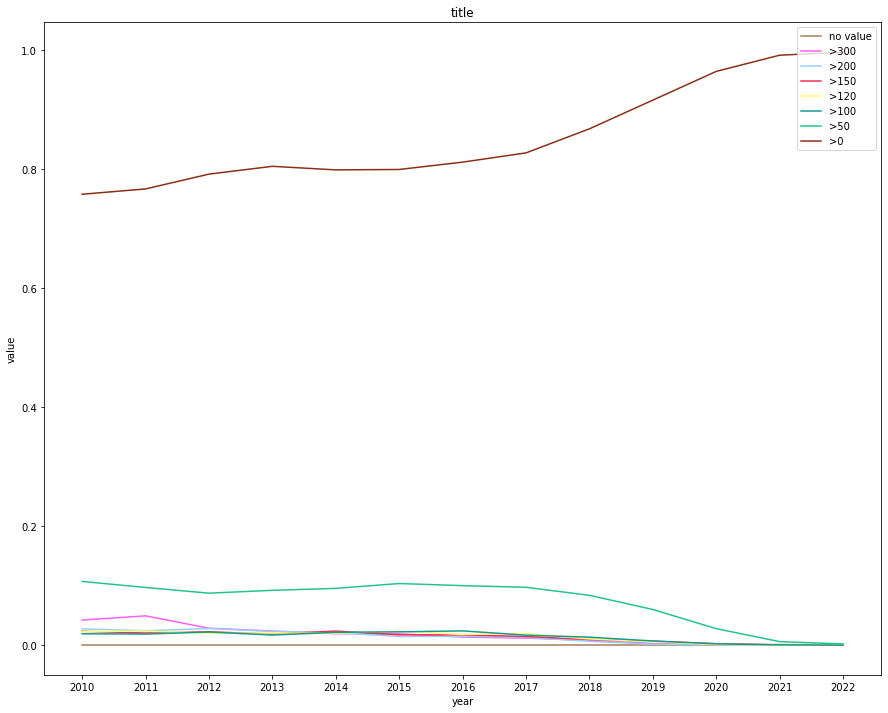

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

plt.rcParams["figure.figsize"] = (15, 12)

x = [
    '2010', '2011', '2012', '2013', '2014', '2015', '2016',
    '2017', '2018', '2019', '2020', '2021',
    '2022'
]

def sort_colors(colors=mcolors.XKCD_COLORS):  # 949
    by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                            for name, color in colors.items())
    cols = [name for hsv, name in by_hsv]
    cols = random.choices(cols, k=40)
    return cols
cols = sort_colors()
# cols = [color for name, color in mcolors.XKCD_COLORS.items()][200: 240]

for i in range(cite_year.shape[0]):
    y = cite_year[i]
    plt.plot(x, y, color=cols[i], label=reverse_cite_map[i])

plt.title('title')
plt.xlabel('year')
plt.ylabel('value')

plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.show()

3. 高citation文本内容/低citation文本内容

In [ ]:
df = df_abstract.copy()
df['cite'] = df['cite'].astype(int)
df[df.cite<2]

,title,abstract,submit_time,comment,cite,comment_label,language,cite_label
161,CITYELEC: a global solution approach for the e...,Urban mobility electrification is a high compl...,2010,world electric vehicle journal,1,J,EN,7
181,2007 Nissan Altima-2351 Hybrid Electric Vehicl...,The U.S. Department of Energy-s (DOE) Advanced...,2010,idaho national labinl idaho falls united states,1,J,EN,7
204,An analysis of the cost of vehicle-to-grid wit...,This paper presents an analysis of the cost of...,2010,electromotion,1,J,EN,7
207,Virtual power plants with electric vehicles,The benefits of Electric Vehicles (EV) aggrega...,2010,european conference smartgrids and emobility,1,C,EN,7
219,Electrification potential of the car__n estima...,An electrification of vehicles can contribute ...,2010,world electric vehicle journal,1,J,EN,7
...,...,...,...,...,...,...,...,...
46049,Policing in unsettled times: An analysis of cu...,This dissertation examines how actors within a...,2016,university toronto canada,1,U,EN,7
46050,Coyote Settles the South,"One night, poet and environmental writer John ...",2016,university georgia press,1,U,EN,7
46052,The Home Movie Imagination in UK and US Fictio...,This thesis examines the representation of hom...,2016,university warwick,1,U,EN,7
46054,A novel pricing mechanism to optimally schedul...,As an emerging solution to mitigate the proble...,2017,ieee vehicular technology conference vtcfall,1,C,EN,7


In [ ]:
# df[df.cite>5000].at[45537, 'title']
df.at[46054, 'title']

'A novel pricing mechanism to optimally schedule the charging demands with user utilities'

### 2. 数据加载

In [ ]:
print(len(data_ready))
print(len(df_abstract))

46065
46065


In [ ]:
num_topics = 50
n_rows = 13
n_cols = 3

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [ ]:
import pickle

with open(f'lda_{num_topics}_0507_no_energy_en.pickle', 'rb') as handle:
    lda_model = pickle.load(handle)
    reverse_map = dict((lda_model.id2word[id],id) for id in lda_model.id2word)

### 3. 关键词提取

In [ ]:
# 分组

group1 = [0, 1, 2, 4, 5, 6, 8, 12, 14, 15, 17, 18, 19, 20, 23, 25, 29, 32, 33, 41, 42, 43, 45]
group2 = [3, 7, 24, 26, 30, 31, 37, 47]
group3 = [10, 11, 13, 16, 21, 22, 34, 35, 39, 40, 48]
group4 = [9, 27, 28, 36, 38, 44, 46, 49]
groups = {"policy": group1, "fleet": group2, "system": group3, "component": group4}

In [ ]:
def sortDictValue(dict, is_reverse):
    '''
    将字典按照value排序
    :param dict: 待排序的字典
    :param is_reverse: 是否按照倒序排序
    :return s: 符合csv逗号分隔格式的字符串
    '''
    # 对字典的值进行倒序排序,items()将字典的每个键值对转化为一个元组,key输入的是函数,item[1]表示元组的第二个元素,reverse为真表示倒序
    tups = sorted(dict.items(), key=lambda item: item[1], reverse=is_reverse)
    s = ''
    for tup in tups:  # 合并成csv需要的逗号分隔格式
        s = s + tup[0] + ',' + str(tup[1]) + '\n'
    return s

def build_matrix(co_authors_list, is_reverse):
    '''
    根据共同列表,构建共现矩阵(存储到字典中),并将该字典按照权值排序
    :param co_authors_list: 共同列表
    :param is_reverse: 排序是否倒序
    :return node_str: 三元组形式的节点字符串(且符合csv逗号分隔格式)
    :return edge_str: 三元组形式的边字符串(且符合csv逗号分隔格式)
    '''
    node_dict = {}  # 节点字典,包含节点名+节点权值(频数)
    edge_dict = {}  # 边字典,包含起点+目标点+边权值(频数)
    # 第1层循环,遍历整表的每行信息
    for row_authors in co_authors_list:
        row_authors_list = row_authors.split(' ') # 依据','分割每行,存储到列表中
        # 第2层循环
        for index, pre_au in enumerate(row_authors_list): # 使用enumerate()以获取遍历次数index
            # 统计单个词出现的频次
            if pre_au not in node_dict:
                node_dict[pre_au] = 1
            else:
                node_dict[pre_au] += 1
            # 若遍历到倒数第一个元素,则无需记录关系,结束循环即可
            if pre_au == row_authors_list[-1]:
                break
            connect_list = row_authors_list[index+1:]
            # 第3层循环,遍历当前行词后面所有的词,以统计两两词出现的频次
            for next_au in connect_list:
                A, B = pre_au, next_au
                # 固定两两词的顺序
                # 仅计算上半个矩阵
                if A==B:
                    continue
                if A > B:
                    A, B = B, A
                key = A+','+B  # 格式化为逗号分隔A,B形式,作为字典的键
                # 若该关系不在字典中,则初始化为1,表示词间的共同出现次数
                if key not in edge_dict:
                    edge_dict[key] = 1
                else:
                    edge_dict[key] += 1
    # 对得到的字典按照value进行排序
    node_str = sortDictValue(node_dict, is_reverse)  # 节点
    edge_str = sortDictValue(edge_dict, is_reverse)   # 边
    return node_str, edge_str


def modify_str(node_str, edge_str):
    # edge_str = pd.read_csv('edge.csv',encoding='gbk')
    # edge_str.shape
    edge_str1 = edge_str[edge_str['Weight']>3]
    # edge_str1.shape

    Source = edge_str1['Source'].tolist()
    Target = edge_str1['Target'].tolist()
    co = Source + Target
    co =list(set(co))

    # node_str = pd.read_csv('node.csv',encoding='gbk')
    #node_str

    node_str=node_str[node_str['Label'].isin(co)]
    node_str['id']=node_str['Label']
    node_str = node_str[['id','Label','Weight']] # 调整列顺序
    #node_str

    # node_str.to_csv(path_or_buf="node.txt", index=False) # 写入csv文件
    # edge_str1.to_csv(path_or_buf="edge.txt", index=False) # 写入csv文件
    return node_str, edge_str1

def cowords(document_topic_dist=document_topic, year=2010, group="policy", text=data_ready):
    # node_str & edge_str
    topic_indices = []
    for x in range(document_topic_dist.shape[0]):
        topic_indices.append(np.argmax(document_topic_dist[x]))

    topic_id_lst = groups[group]
    dataset = [" ".join(text[i]) for i, x in enumerate(topic_indices) if x in topic_id_lst and df_abstract.at[i, "submit_time"] == year]
    print(len(dataset))
    node_str, edge_str = build_matrix(co_authors_list=dataset, is_reverse=True)
    
    # save
    # str2csv('node.csv',node_str,'node')
    # str2csv('edge.csv',edge_str,'edge')
    
    # modify
    # node_str, edge_str = modify_str(node_str, edge_str)
    return node_str, edge_str

year = 2010
group = "policy"
node_str, edge_str = cowords(year=year, group=group)


1445


In [ ]:
def str2csv(filePath, s, x):
    '''
    将字符串写入到本地csv文件中
    :param filePath: csv文件路径
    :param s: 待写入字符串(逗号分隔格式)
    '''
    if x=='node':
        with open(filePath, 'w') as f:
            f.write("Label,Weight\r")
            f.write(s)
        print('写入文件成功,请在'+filePath+'中查看')
    else:
        with open(filePath, 'w') as f:
            f.write("Source,Target,Weight\r")
            f.write(s)
        print('写入文件成功,请在'+filePath+'中查看')

str2csv(f'node_{year}_{group}.csv',node_str,'node')
str2csv(f'edge_{year}_{group}.csv',edge_str,'edge')

NameError: ignored

In [ ]:

def modify_str(file_edge='edge_unit.csv', file_node='node_unit.csv'):
    edge_str = pd.read_csv(file_edge,encoding='gbk')
    # edge_str.shape
    edge_str1 = edge_str[edge_str['Weight']>10]
    # edge_str1.shape

    Source = edge_str1['Source'].tolist()
    Target = edge_str1['Target'].tolist()
    co = Source + Target
    co =list(set(co))

    node_str = pd.read_csv(file_node,encoding='gbk')
    #node_str

    node_str=node_str[node_str['Label'].isin(co)]
    node_str['id']=node_str['Label']
    node_str = node_str[['id','Label','Weight']] # 调整列顺序
    #node_str

    # node_str.to_csv(path_or_buf="node.txt", index=False) # 写入csv文件
    # edge_str1.to_csv(path_or_buf="edge.txt", index=False) # 写入csv文件
    return node_str, edge_str1

node_str, edge_str = modify_str(file_edge=f'edge_{year}_{group}.csv', file_node=f'node_{year}_{group}.csv')

In [ ]:
import random

categories = [{"name": 'A'}, {"name": 'B'}, {"name": 'C'}, {"name": 'D'}, {"name": 'E'}, {"name": 'F'}, 
              {"name": 'H'}, {"name": 'I'}, {"name": 'J'}, {"name": 'K'}]

degree0 = 5
degree_growth = 0.01
K = 4

nodes = []
node_str_ = node_str[1:20].reset_index(drop=True)
for i, row in node_str_.iterrows():
    if i < K:
        node = {
              "id": str(i),
              "name": row['id'],
              "symbolSize": row['Weight']/40.,
              "x": np.random.uniform(-1, 1, 1)[0] * 1000,
              "y": np.random.uniform(-1, 1, 1)[0] * 1000,
              "value": 0,
              "category": i
              }
    else:
        node = {
              "id": str(i),
              "name": row['id'],
              "symbolSize": row['Weight']/40.,
              "x": np.random.uniform(-1, 1, 1)[0] * 1000,
              "y": np.random.uniform(-1, 1, 1)[0] * 1000,
              "value": 0,
              "category": K
              }
    nodes.append(node)

def check_nodes(name):
    for i in range(len(nodes)):
        if nodes[i]["name"] == name:
            return i, nodes[i]["category"]
    return None, None

def check_category():
    """是否存在未着色的节点"""
    for i in nodes:
        if i['category'] >= K:
            return True
    return False

links = []

while check_category():
    for i, row in edge_str.iterrows():
        src_id, src_cate = check_nodes(row['Source'])
        tgt_id, tgt_cate = check_nodes(row['Target'])
        # print(src_id, src_cate, tgt_id, tgt_cate)
        if src_id is not None and tgt_id is not None and src_cate != tgt_cate:
            if src_cate < K and tgt_cate >= K:
                nodes[tgt_id]["category"] = src_cate
            # elif tgt_cate < 10 and src_cate >= 10:
            #     nodes[src_id]["category"] = tgt_cate
            # elif src_cate < 10 and tgt_cate < 10:
            #     minn = min(src_cate, tgt_cate)
            #     # if src_id > 10:
            #     #     nodes[src_id]["category"] = minn
            #     if tgt_id > 10:
            #         nodes[tgt_id]["category"] = minn
            # else:
            #     continue
            link = {"source": src_id, "target": tgt_id}
            links.append(link)
    break

In [ ]:
import json

data = {"nodes": nodes, "links": links, "categories": categories[:K]}

# Directly from dictionary
with open('json_data.json', 'w') as outfile:
    json.dump(data, outfile)

# 2. 量化特征

In [ ]:
import pickle

with open('document_topic_0507_no_energy_en.pickle', 'rb') as handle:
    document_topic = pickle.load(handle)

with open('topic_word_dist_0507_no_energy_en.pickle', 'rb') as handle:
    topic_word_dist = pickle.load(handle)

### 2.1 主题特征

##### 2.1.1 主题随时间的变化

In [ ]:

def year_topic_distribution(document_topic=document_topic):
    year_lst = list(df_abstract.drop_duplicates(subset=["submit_time"]).sort_values(by=['submit_time'])["submit_time"].values)
    year_topic_dist = np.zeros((len(year_lst), num_topics))

    for id, year in enumerate(year_lst):
        id_array = df_abstract[df_abstract['submit_time'] == year].index.values
        if id_array.shape[0] != 0:
            data_ = document_topic[id_array]
            year_topic_dist[id] = np.mean(data_, axis=0)
            year_topic_dist[id] /= np.sum(year_topic_dist[id])
        else:
            year_topic_dist[id, :] = np.nan
    
    # 每一行加和是否为1
    print(np.sum(year_topic_dist, axis=1))
    return year_topic_dist

year_topic_dist = year_topic_distribution()

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


##### 2.1.2 期刊的主题的分布

In [ ]:

def space_topic_distribution(document_topic=document_topic):
    comment_lst = df_abstract.drop_duplicates(subset=["cite_label"]).sort_values(by=['cite_label'])["cite_label"].values.tolist()
    comment_lst = [int(ele) for ele in comment_lst]
    # print(comment_lst)
    comment_lst = [ele for ele in sorted(comment_lst)]
    # print(comment_lst)
    comment_lst = [str(ele) for ele in comment_lst]
    # print(comment_lst)
    cite_name = [reverse_cite_map[int(comment)] for comment in comment_lst]
    print(cite_name)
    comment_topic_dist = np.zeros((len(comment_lst), num_topics))

    for id, comment_type in enumerate(comment_lst):
        id_array = df_abstract[df_abstract['cite_label'] == comment_type].index.values
        if id_array.shape[0] != 0:
            data_ = document_topic[id_array]
            comment_topic_dist[id] = np.mean(data_, axis=0)
            comment_topic_dist[id] /= np.sum(comment_topic_dist[id])
        else:
            comment_topic_dist[id, :] = np.nan
    
    # 每一行加和是否为1
    print(np.sum(comment_topic_dist, axis=1))
    return comment_topic_dist

comment_topic_dist = space_topic_distribution()


['>300', '>200', '>150', '>120', '>100', '>50', '>0']
[1. 1. 1. 1. 1. 1. 1.]


### 2.2 关键词特征

In [ ]:
def read_keywords( group, topic, file='keywords_m.csv'):
    df = pd.read_csv(file, encoding='latin1')
    keywords_lst = []
    df = df[(df['group'] == group) & (df['topic'] == topic)]
    for idx, row in df.iterrows():
        temp = []
        for w in row['keywords'].split(" "):
            if w in reverse_map.keys():
                temp.append(w)
        if len(temp) > 0:
            keywords_lst.append(" ".join(temp))
    return keywords_lst

def read_keywords2( group, file='keywords_m.csv'):
    df = pd.read_csv(file, encoding='latin1')
    keywords_lst = []
    df = df[df['group'] == group]
    for idx, row in df.iterrows():
        temp = []
        for w in row['keywords'].split(" "):
            if w in reverse_map.keys():
                temp.append(w)
        if len(temp) > 0:
            keywords_lst.append(" ".join(temp))
    return keywords_lst

# keywords_lst = read_keywords(group="component", topic="powertrain structure")
keywords_lst = read_keywords2(group="policy")
words1 = keywords_lst

In [ ]:
keywords_lst = ["artificial intelligence", 
                "mathematics", 
                "geography", 
                "engineering", 
                "philosophy", 
                "business", 
                "physics", 
                "environmental science",
                "geology",
                "history",
                "sociology",
                "economics",
                "material science",
                "chemistry"]

keywords_lst_new = []
for wd in keywords_lst:
    temp = []
    for w in wd.split(" "):
        if w in reverse_map.keys():
            temp.append(w)
    if len(temp) > 0:
        keywords_lst_new.append(" ".join(temp))

keywords_lst = keywords_lst_new
words2 = keywords_lst

##### 2.2.1 关键词-主题分布

In [ ]:
from apyori import apriori
import csv

def words_subtopic_distribution(group="policy", topic_word_dist=topic_word_dist):
    words_subtopic_dist = np.zeros((len(groups[group]), topic_word_dist.shape[1]))
    for i in range(topic_word_dist.shape[1]):
        words_subtopic_dist[:, i] = topic_word_dist[groups[group], i] / np.sum(topic_word_dist[groups[group], i])
    return words_subtopic_dist

def keywords_topic_distribution(key_words_lst, topic_word_dist=topic_word_dist):
    word_topic_dist = np.zeros((len(key_words_lst), topic_word_dist.shape[0]))

    for i, wd in enumerate(key_words_lst):
        wp = 1
        for w in wd.split(" "):
            if type(w) == str:
                id = reverse_map[w]
                wp *= (topic_word_dist[:,id]/np.sum(topic_word_dist[:,id]))

        topic_dist = wp / np.sum(wp)
        word_topic_dist[i] = topic_dist
    
    return word_topic_dist

word_subtopic_dist = words_subtopic_distribution()
word_topic_dist = keywords_topic_distribution(key_words_lst=keywords_lst, topic_word_dist=word_subtopic_dist)


[热力图](https://echarts.apache.org/examples/zh/editor.html?c=heatmap-cartesian&lang=ts&code=PTAEAcCcFMBdYJbUgWgQcwHYHsYCgBjbTAZ1lAAtsBXSE0AXlAG0ByAQ0kQDMECF2AG1AJMsaIMEZomAtFYAaPKFYBbdrArR1iAiUXLW6aNnSR24CgE8DKmelHRko9LdaWEg7CWyWbSlQAjahJHEn0A92tQvTcZADcESGJVGVghUBJ-GTk3Y2wvdH9DCgQyXGKVH34C00rWaCIcVT4Iwx1nDKykWXlIgi0WskgbAF0Abjw8EAgYeCRUDBx8JrJQABN2K3oGNgSklLShRTtMROTMVLEMzfVjE9ZuaglQAew-PqqQ9NF2QMFoKBGsRsKoxpNpmAoHBEMg0FhcNBIatyJt0owWMwAAwKHEAVlGCmxCgAjKTCcSAEy4ik4gDMNKJOIALIziXi2TiAGychQAdl5AA5eQBOXkknFY2mksmU6Uk6nM-UMkny1mqpmkjl0-U8pWakkCrny4X64kksVmnGU-nSylknWaynUuVOhkEolknF8ilkr2-hTUqWehQM4PMMms8NkjnRhQ8uMCuPCuNiuMShQeiMywMBhW5kMkhnGwuskV5jkkjXZkk8ks1gU-wvCwV5sUKgM2zOdmOd6lN7OUhmu5hB8lE6l-ikutnUsPThRRhexhcJhdJhcphdphcZx2jnMjyeT3cM8sT0ms1sXkmV8OTuu7gVZyfCl-ksXvrsDl2RhfOgsDyHRcKTDflQNJUMIKDCD5yJBkl3gzM2WLFD-TQ4VqzPNCMyzFU_yQ_MBxVFUzVI0l9xVSsRxVHlz2YFVnwgkk32Y9tw2HbloIIhjA0VaCVQpKNx2YdUoKJVkYIk0M2VZRDROQ6tWTXaSN2krdpLFEd1RZISczNdUXT0osQOkkk5OMysDNJHkOzMgUlNJFtjM_PSu33SSyQHSS5zcuDmFjQDKxEjkpICmT9w5eSORXIkORU8K1PC4URw5Hc4tJXSMqrELSWpLNKxVcMrO7bKOQHStbOrSsjQpSsNPCi1SvC9y6sDHjQqMjLgPDBMRNstkeTCnl_L1QbkN6-NxqSnkGro8aM2rKqFq65hbMEolbNZfdbKiilbIS2yZqchb0rWwMcSW9rAKG1ahuLUZRkIYg1jRdgMWYYlQBxb6ADpBRtEU-SxLERXMrlazpUHCTwL6yVAElfr5PkuSxG08TxEVKUFTGof1WGfupBHfrpTHKWZQUuVRvEQbxYGmwJhRQAZP6-UpPk6TpG06WBrlmR5i0Ya-1lieRvkWJBrE6bBjnmXxr6OVASlfoprG8X5wUAbpQUsVJoWfp5P7KbpEURUFIsi21kU8U1_WmYFUA-V-vEh0xumpdRossXln7hUd_6oaHHWLdB83rbt0AxT-5lIcprkOZpvELSxW8I4zP6RS5HW-UFLHyb5JOgZLRmEfhxHvaBot1exylcf5tOibpEmU5psGRSl03QextOWcRykuRN9HBT5EU6VvLkzaF-GfqxX6pfMykZZFZkk_F2vi-zBGmdnzWMZNjuWJdrP5fhonEYte1mTRiHc4B5l-6npmWdn2uU6vrFd5d5G6Q3-GRdnvkMcc7kw9gqDmv8maK3LvaBOFok7q1JteWG8NDYv3jsyZGut-6ax5pTR-jsmbMl-gqLECdR4g3MivDUyCmZ-xFHPKsFDrYf0zubCBkdt7EKpqbYBdIr7MgHjLfB6dZ5FmHiPdeVYbaAMFI6Ghpcmbl0zgqc2P9R7mShueeR-ZiZckBj_E2zJ24T1zgzTeJk_pc3BqjPhbNTY2ldLDImM857tzZjjZectDQ_3vkLM-iiuErzZjI8WRZsZmKJs4uecsuQ0wnkYjBUtMbLz8U_Th6sV7a1zjzNGgoY5yIPKAf-v12ZFhke3LGWcWJU1SaARWL9k7D3JhovEeiH5KEKYbaB_Meke1aTHeWRMHaiPMgnFGlMFR00NLUv2iM-FGOTrXNmVNZGOMKVHURE9W4c37gPFGtdakiLnhkiUY8C4WlvO3PWHSz7TxKVzUmBchyo3tP3FJNzFFROxjzDGzogHYN1oc5-JNM7e1eR_IxANawelhs_Thus-YIpburDGFMzG904ZzdWsSC5ayxsPDeLMokr3NmjVhCoLQU2obxZmnCV4UzyfaXO_MLQ8yFizEW58-bxzRrrE2CprmwsgQEgGKLO5ZxHgqLO7KmaoOITaGOgjUVc1aVLGVBDI7O0xqQ7GCSR41I6SzP2RCBF5ItKbYeEoUbUpZhs4hmt2YUzprfZOLF1VHLyXE62KM863lae6u5pCR5S3Fi7TRKc1m90ib9LGiSr44zRlQ2J7rgXOipjAqFoMk42mNE9UA-bQC_XUOAAAFE8WQiBiCgBLQgcQqgACUoAADeygC1trmLQTALBa3aAjISEQdbsT9p7aoUcoxQAAB8J0qBQKwCYrb80AF960Ql8JWrtTAW35tgNgAoiBwAAC5m0LogN4WtCBiBHtYDu8ArBW2LoCKAMwCB1hHq3QWrQGAKCwCvTTAApLYAtN6r0SgA_ex9AAPAAghBsob6T2wCsOAaAV6CAaGgOgCogH81vSPVQWgJBH35pIOAKQsAoMwHYPBttxGqAAHcj3cCECQJEbbF3gdbVYGDcHj1tsQ8h1D6HMMjGwxsDQVGxPbCI5kUjtaKPQAk--ttJB6OMeY6xgt7Gl2PsSCQagQgACyFhqMFpaJgI9OIT3qAg0ejMJ60OCAINQQQfwARHtgJAZ40ncA9B_SoKgkAEAAC9iDpEEKJgE3A_OsDkGIZAonAjYHgKCEDeIwPadbSxwL0ASBHuYCepTBbMDsFSFegACtQWQFBQAAGFODrFE9upDKH_MKdgMWxrYn0hHretJ_NLnAgSBMzRzIqnQBMcECxk9GWRvaEsOwUIuXeMjYHdoAAyohtzy2VujfYOsbAdGABCghaC2ZBn1mjKm9sHZq7USAV7IDoECOwEtM9t7pPrXenbWmaM_aXa2p6i7xhAA)

In [ ]:
words1.reverse()
words1

['global',
 'renewable',
 'clean',
 'life',
 'sustainability',
 'life cycle',
 'regenerate',
 'refurbish',
 'recycle',
 'recover',
 'disposal',
 'secondary',
 'gasoline',
 'gas',
 'fossil fuel',
 'polluted',
 'pollutant',
 'smog',
 'emission',
 'landfill',
 'conversion',
 'circular economy',
 'discharging',
 'charging',
 'catalytic',
 'health',
 'storage',
 'density',
 'depth discharge',
 'resistance',
 'voltage',
 'capacity',
 'ac',
 'aging',
 'grid',
 'pole',
 'pack',
 'storage',
 'photovoltaic solar',
 'fuel cell',
 'ultracapacitor',
 'battery',
 'commutator',
 'sensor',
 'rectifier',
 'inverter',
 'converter',
 'powertrain controller',
 'planetary powertrain',
 'transmission',
 'internal combustion engine',
 'shaft',
 'generator',
 'gearbox',
 'gear',
 'clutch',
 'flow',
 'flow',
 'integration',
 'speed coupling',
 'torque coupling',
 'coupling',
 'coupling',
 'coupling',
 'framework',
 'configuration',
 'architecture',
 'torque',
 'rating',
 'overload',
 'magnetic flux',
 'flux',


In [ ]:
words2

['artificial intelligence',
 'mathematics',
 'geography',
 'engineering',
 'philosophy',
 'business',
 'physics',
 'environmental science',
 'geology',
 'history',
 'sociology',
 'economics',
 'material science',
 'chemistry']

In [ ]:
word_topic_dist1 = keywords_topic_distribution(words1)
word_topic_dist2 = keywords_topic_distribution(words2)
word_word = np.zeros((word_topic_dist1.shape[0], word_topic_dist2.shape[0]))

import numpy as np
from numpy.linalg import norm
 
def cosine_similarity(A, B):
    # compute cosine similarity
    cosine = np.dot(A,B)/(norm(A)*norm(B)) 
    return cosine

for i in range(word_topic_dist1.shape[0]):
    for j in range(word_topic_dist2.shape[0]):
        word_word[i][j] = cosine_similarity(word_topic_dist1[i], word_topic_dist2[j])


In [ ]:
for i in range(word_word.shape[0]):
    for j in range(word_word.shape[1]):
        print(f"[{i}, {j}, {word_word[i][j]*10}],")

[0, 0, 0.07258261039524125],
[0, 1, 0.9748735598170083],
[0, 2, 0.027248913931732927],
[0, 3, 0.5776212244867562],
[0, 4, 0.27783996635331476],
[0, 5, 0.15714574484468977],
[0, 6, 0.8941841397890598],
[0, 7, 0.13116351458325323],
[0, 8, 1.216862340904808],
[0, 9, 0.15515443150630148],
[0, 10, 0.03761493579601416],
[0, 11, 0.1914137052728196],
[0, 12, 0.2325074352002865],
[0, 13, 0.347430577652148],


分布图

In [ ]:
import csv
import numpy as np
import joypy
import pandas as pd
# sns.set(rc={'figure.figsize':(11.7,8.27)})

labels = keywords_lst

topics = range(word_topic_dist.shape[1])
data = []
for i in range(len(labels)):
    dist = np.array(word_topic_dist[i])
    dist /= sum(dist)
    d = np.random.choice(topics, 1000, p=dist)
    data.append(d)

data = np.array(data)
argind = np.lexsort(word_topic_dist.T)
print(argind)
data = data[argind]
labels = np.array(labels)[argind]


d = {}
for i, label in enumerate(labels):
    d[label] = data[i]

df = pd.DataFrame(d, columns=labels)

# fig, axes = joypy.joyplot(df)
# fig.show()


[ 5  1  2  0  3 12 10 21 14 13 16 17 22  6  4  7 19 15 11 18 20  8  9]


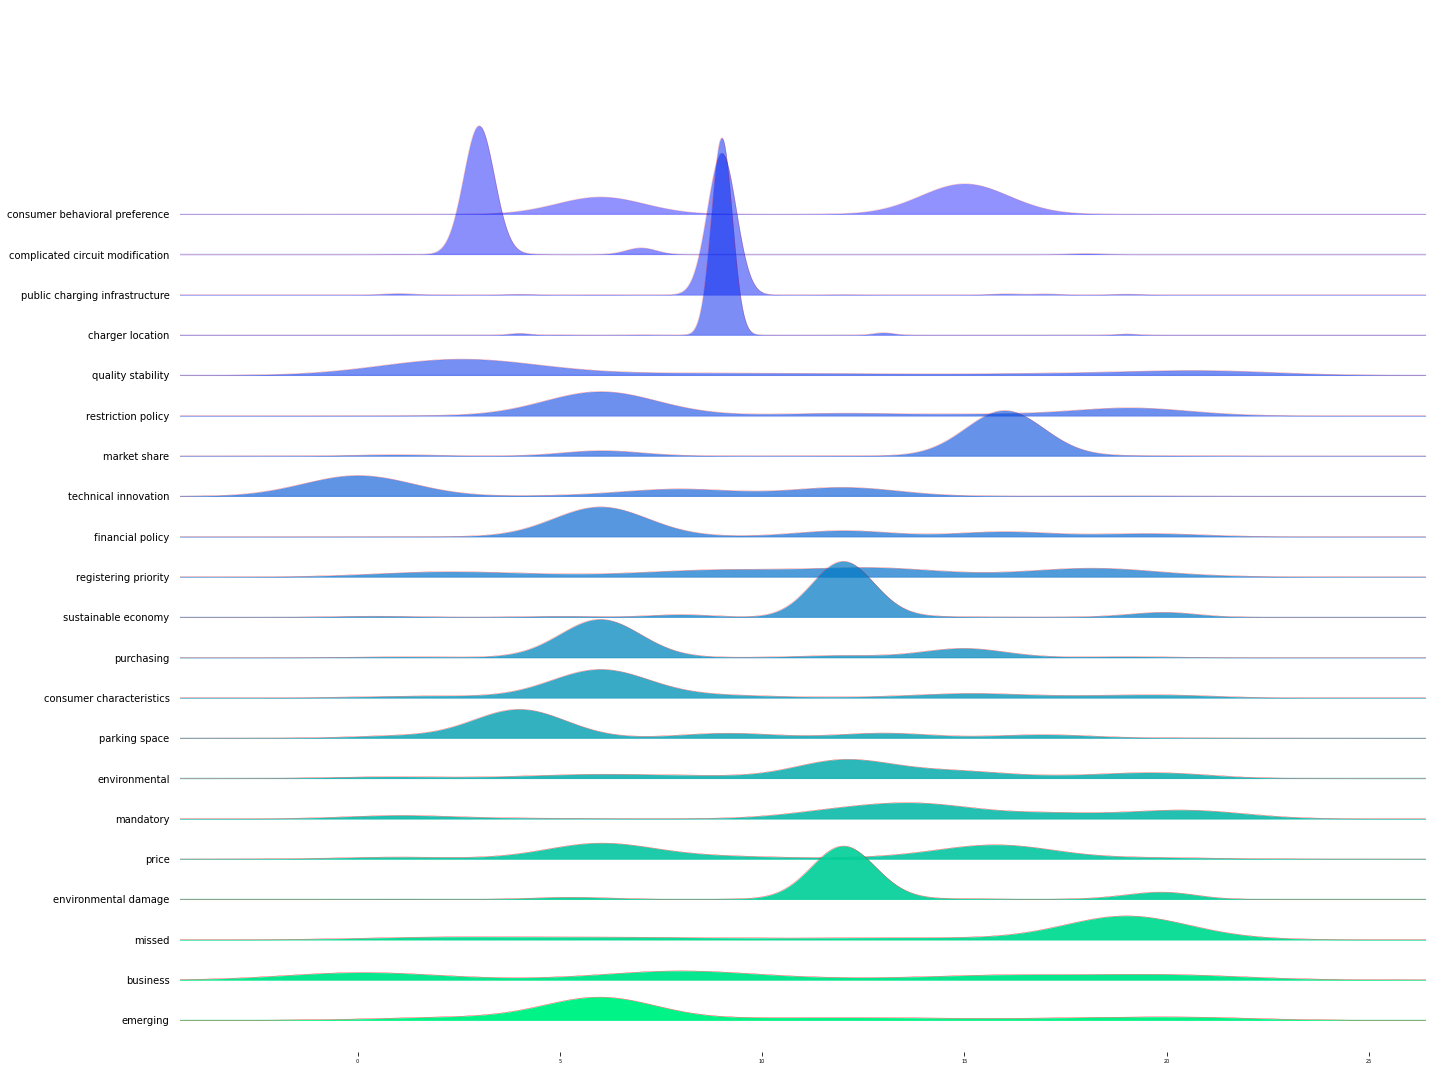

In [ ]:
import matplotlib as mpb
from matplotlib import cm

color_normal = mpb.colors.LinearSegmentedColormap.from_list('自定义的颜色名字',
                                                                          [
                                                                              (0, '#51689b'),
                                                                              (0, '#ce5c5c'),
                                                                              (1, '#fbc357')
                                                                          ], N=256)

fig, axes = joypy.joyplot(df,
                          # column=['lr'],
                          # column=['soc'],
                          # column=['lr', 'type'],

                          # column='type',
                          # column='ep',
                          # column='ep',

                          # by="type",
                          # by="soc",
                          # by=label,
                          # ylim='own',
                          linecolor="r",
                          # linecolor="w",
                          figsize=(20, 15),
                          xlabelsize=5,
                          ylabelsize=10,
                          fade=True,
                          # overlap=3, tails=20,
                          overlap=4,
                          tails=20,
                          # range_style='all',
                          fill=True, linewidth=0.3,
                          # fill=False, linewidth=1,
                          # hist=True,
                          # bins=20,
                          # colormap=plt.cm.Set1, )
                          colormap=cm.winter
                          # colormap=color_normal
                          # colormap= plt.get_cmap(ca_map[col])
                          )

fig.show()

##### 2.2.2 关键词-期刊分布

[绘图](https://echarts.apache.org/examples/zh/editor.html?c=custom-polar-heatmap&code=PTAEAcCcFMBdYJbUgWgQcwHYHsYCgBjbTAZ1lAAtsBXSE0AXgG0ByAPgGYAGLlgGlDsATD36C2ARgCsvAewkix80XLYylbXgF0A3HhAQY8JKgw58RUuQAmAQwCe9BqFYES_PIIC2t2BWg-iG4egujQ2OiQtuAU9iEs0JjoCJjQyCno8TEIADbYJNgxcXyeLLaQsPEARtQkKdAk7iWC4CT2BFR56MWlRXXBzSzg2DkIQbY5oCQESJgE0PGJAG4IkMReibATUzOJ8_FhIxE9ghQIZLgnLAUzR92LltheCAOlgenb07P7gxvWL_Vqgg7lcOgFzrBIHFdPowFA4IhkGgsLhoLDQJYyKA7FtGC4mFwBITQFItAICQIJJSyS5iUIiTSKaAOAzycSACys2kCKRcpkANj5xIA7EKBAAOMWgACcUokxK4jOJEipoCESsp9NA7I1oAkLL1uoknMNbMpvOZRsF2qNotA_KNkptZr1sud3LVxI4uqEqu9LqEWvVAYNpPJqpFjNVEajAi1ivDAgNCZcqpNKaYqotGdV1pzAjt-dATqLbqL8p5sb1quDqc1car-oEDsTepN0sbFpVjetLbrertwsbTvFjbdCirIkrrd90_7gYLk4NtaY8ep5K10cZQb5WuT24E6YPJN3zdPoELx5Lx7Lx4rlo3lJrd83d4NHcfbYld67Gc3vbvO0wxcTcnWA1dKTdcCg0jT9Z3dCC1SDY8hANHVyWTRcMMpJNGWXPkDX3bDtQInlSPtcjL2Ip0JDwgRb2I-9wINFVDzovUtSHRiWPQlweMpf0-PNTV2Ika0PyEgc5yYFiwNE8cM2XYk-xkuM03YhcEOXFjGXTdcXBNP1dLjPkTSIgzD1MsjTQsijQAzE0qNs69yXbBtXMpDljOrNiPI49zbKbBDDJNXimEMrswsM60Jz8iQ7VouKR28iQoO8qcH1s-CuKyvd0vMphswCwqcJskq1T5C1CMZC0j3JC1sxqs97Kai9KolYqLQYlxf18nqn308qFGkrsWIzSKRuEi9WrEp8ZrtFSuxc_rXUmz1cPqtS-vKzSVwtVC-TzQaYsOkyWvJa0CutOqXGtRqLuajNrScphrWW176NOvVlUZGKYwe_y1V-gTjspMzgb1WqIdm87bspF6YvemLuo-9ayuteCVwx5CAYO-0tBhTEbF8Ww8SYJllSEAA6fVxTE6UpGldkOHFJnErwJlo3ZGn6Y4aVpGFflpWlDh-X9Dm6UpfkqfZcVxUZkWmakX1hXFpkWI4KmOHZfl6eFKQdfZEW6bJCXLLbLXhSEIXpX5HXxXZLgpFZ02mS7aWnYkcVhR4cUuHFDhnaZ13lIEmX5akZWOGFeUxf5IRRxKTMiSfKnWdVkX2SkeOdadtXozBqmpG4XXfWj_ls-19nk4qi3-Tpv3hadhnhWlb3Xb9c0Za4O2GakYUs-1p2uI5tMu_FIRbYUeOA64eUB476zjSphn4p75nfWz9kR5rmLqZ91ChfFCvjT97sk7XV0qbtuX_ZZ9khHZfVhR3zcu6EKQVV13OeH5UvXZ3BxNObd4rGj_kIQWc81Z7kLj7dkjtY7CjloGRmADzb6mvh_bWH9lYfwnrbNBJ4gHaxft7Y0YlmZgMIX9Iuj8OAQOlBAoWgZ25J0wlffkXBGG22LrrB22dgwcxYmHLg29-4i39o_R20dXb4SAazCeD8HaPzlsfdCQikyF1FlbP2x8B6t1QWw9BmsK7R1lvKP2c9dYfg0UQhQWtUrbyfvXCeMhUKyOasveUzMkFiW9oLSeas9IcNlgHBO2tuHW0EeFUqy9j5SLvgPcJDNXYmk3JrJm8DWbRxZlveKqTNEWznmJQMSsjbhIKSRPUmtcn6wdtk3R2tKldmpnzZ2yt449y9gPGxMS7IqipvreUXAE5t0CUbFsHMip6mlk3F-qsVEKE_q7LshcuHR0nvzHu0okEJxWWdDBPtUqf0nkggOnCd5VS0cLOmn92lcFbpPfZVSMHFw_mLaUXAOBf04b0hqYdvliwEfA5m0cUlJwtDFDJN8umcINi_auR0r6oRVEgq22yvnx1didC2WdWZt1ttYnBiKDncx4CM6QjNkGiLttiwpy8Nk3NFm82matrphxkPzZW-odle1YRzO6mpBmTyfhnBW296F0v6RIa-bcvly31NbCh0TCxdxjj3MWgd5bx0jonDmCUhXC2LhwehLNvkB35q7O0m4pBF1SgzOmXDbk7MmUwO0PEi7xw_qKgOfj_ZWuMUXJuyDuCoW-eot1S9uYiCZifCBUSvZqwWmHaRqEX79yNlw5WrsSyp0FpmoWjs25iyzjm2J1MJ6cPgd8hQIr-Q7ydJufeOsIHyzEvrE1Mcy3MkLrLQMjsH6-lQozCNTpDKayQV8kZstIH1wed2rstri5cJVP3Oenz4quqdIjNOQtvn90_iqEZxdXZljjNLetfLpAjKnTO09sTuby3mdwyOcLH73trhg7x3AJ6pX7UOj9GtBmpV2Y3MWscP2GS4CvfhfD5UOy5R-rsMryHexZm3eWTqd5unEnakBj8fZ018dXe8dJqYYaGdraOIyxYd2VIXO5_dN5gIFq6-8m5ubxToU3XWvzen3g9YwnW9DGbGlVhXOj6DqZrsiSLSOJqSPEmQ8AvmIhS6OzbZJuy4oV6doNvKBQfMTURtYvZLur74q6oNtnT-erMwF2qSvL28rJ50z_gbOzpmOMyyNi_QMIgTXawnh3TukMZZ2xoyc6QWdaNJ1MyFKm_tPmXqttbBB-csxhx2SasNysH6-P47mIVBsGa23lvzHZoiwyj0vl7Kmj9-4R0DgnaQnm36OZ6crK2eKc7bw7oAjBLNDMmpGapnuO9ho9qKcGg2m8TVYri1qQyMrBacJ4KlOWSjGH9aXhW4u-oxaiNSr86Jk2Yq2s-VHe1Xt-b7o7uw30NNda019BHKennhFhcrSgktqKuGnbkRgzDDz1n0Oe--uLhFDXwIgfFJWECX5sbQoa8uFWEUwv46GIVfLBb63rcLMWezIeeJlSugOLMB45OtvnYJ0hBmC3of93WojNsd0MoXb-SD65e04d8j-bPSX1YUKEu2j9dZgoF1N5e1OK6lcfmJCu1XMyhVgfHQnxsHYPPgZL0aadjuB37goNu2a4smj3kXGQYjP4jP0U7Du0zrZa1QqN1WrdZaIbi6sgcMsB6f24JHT-282P7S0bxpB1vZao_t_S6mFdpHwsZt_B20eXkrcYfQl-1GIGiJM_86siXhYRL9jHT5LMU-9nqwzB57bnbiYNh3JFgZ6uUfx4nvmsXR44owfXUTE9_bRb5w3g51Mc_1o1bLXWruh9S-5nih5gcr2i4m-yoB-oTWxoRxugO0-Wk8yzojxmk9Gbzri72MOCcJ4J2Voe33E3VVqhlZvHZXO_d4PzgamZiXuBB-rVnbbcXrUw47ZOFydRtp5S0ACY8nNhkNMz5Yc78pMV4GFvYCUM4WcO4gJsc6luAVRkF3kEDpUC80t10P4h0ZE4tc09QdNvY75RZW0v45YO4aJ4Y05-87YTVzkvl8kKCDlbV0UwdNdcddYmD6VNYUEjYDZvkHlS5PMx0hVfd-YXF7YZMRC7FyMwcj5LEX02Nt0JRZVZdNl0VI4UlCZiAsQfAAAPAANQmGoGgDxBxFsCphgGsGoHmAAAoAAzagOYRAYgUAdwywgQMYAIAASlAAAG9PBQAjBaBMBQAABZXwCgKmSwwI2wCw4I2AAIVcLQUIvQAAXwEBQAAElMBPCUgxh7B8jCAzDyBnhMAbCcg7CHCSZnDoBXCPDvDfDgR4jAiUgsiwjIjojYjIB4iki_BUiUh-jMBBivBciaiijQAABqMoiozAKomowoPw-I5wKI0AUAHIaAMITAawAALmGIOIOMcIuNYAAAUfCOhQAABhcoawFgLQaIoo6I4YHIcoC4iI74g42AbAEYRAcAAEoE0AFYEgagCYJIiEy4q42AewcAaAC4lgSwRATAagGgJoaIg4hoi4hopouw5oK4yw4kjI0k6Ack4EwoDE54awawI4kIK4_4DYUgXoi4-kAkjECYAgagP4qoI4i4yEOwr48k2wJII4gAQQsPOABL5JRLRIxIIF8GOMuDZOuJJguKoFoBIDpNACqBoFOPKHsAAHFogLjPCJgSBaS-SSBwBRhYAAAZeoJUq4q4kgKgAAdzFMgDJL5IONGFSAAGUUTRSkSvSDiiA8hIAMSABiZk94o0r0lU9EwQOwH0jolgYM0AAovkqEg4jI84d01IT0mMn07Af00AW0nIe0osyUkY2wf4WoeUxU6M0ADMtUjU9ALUo0m47EBwQ0vkgALwuOGWbIOPtMgCQBIFuL5P2JjMwFsA2AxIeLmAoBeLeO1ORNRMzMxNqBBK8D3NjNBMgH-FXOyLDMcGyK8AxN-PKDPNABCK8AjPsCjOXJjIxCOATMEGTONFsF1jzJ_OLKuJgFOOQBKPvJtMeJ2ICPAHKDXMNNAGiAQHCO_JjKWHKGhNsIaDJnQqphwuaOgHcK4FCIECIpIrsPcIkFCJhB_IOJwsgF_NwGsDxCIqIHYvcJooaBqKYrwtYrqDHPsOcCIpErIprkSjwtIpIAEqYtGPiKwp_J7MEHtIIBBMgBfK9J9OiEzJUqYoIAsIuKQqiC8BICpm4svNvMsuMrTKMvsFMuQosqsovOsFsqsvsAcp_MgC4AuOsusFyNABQCmAQFEoJC0FADAF5MEq9P_MCuCuWLCoisVGioqnzJ_LIHKFgFlJlMzJQHcMSu9BWJSugEzCipisosypjMSGsDyvQCjMKuKqitCskoqvSqEFCJqoOPAqysjMzIkoGvcMMp_IqJyByAuOovODhJyHcMxL_JYG6rioLOWqYoKL0DAocqHMcKbIOM-I2qAA)

In [ ]:
comment_topic_dist = space_topic_distribution()
comment_word = np.dot(comment_topic_dist, topic_word_dist)
np.sum(comment_word, axis=1)
print(comment_word.shape, comment_topic_dist.shape, topic_word_dist.shape)

['>300', '>200', '>150', '>120', '>100', '>50', '>0']
[1. 1. 1. 1. 1. 1. 1.]
(7, 39499) (7, 50) (50, 39499)


In [ ]:

def keywords_comment_distribution(key_words_lst, comment_word_dist=comment_word):
    word_comment_dist = np.zeros((len(key_words_lst), comment_word_dist.shape[0]))

    for i, wd in enumerate(key_words_lst):
        wp = 1
        for w in wd.split(" "):
            if type(w) == str:  # w != fuel
                id = reverse_map[w]
                wp *= (comment_word_dist[:,id])#/np.sum(comment_word_dist[:,id])
        comment_dist = wp / np.sum(wp)
        word_comment_dist[i] = comment_dist

    return word_comment_dist

word_comment_dist = keywords_comment_distribution(keywords_lst)

In [ ]:
for i in range(word_comment_dist.shape[0]):
  for j in range(word_comment_dist.shape[1]):
    print(f"[{i}, {j}, {word_comment_dist[i][j]*100}],")

[0, 0, 12.13816959438941],
[0, 1, 14.116939157699363],
[0, 2, 16.48859939452173],
[0, 3, 13.346169754649381],
[0, 4, 14.372699646840589],
[0, 5, 16.051870080835894],
[0, 6, 13.485552371063628],
[1, 0, 11.897393456246053],
[1, 1, 14.530612137656341],
[1, 2, 14.681809905957987],
[1, 3, 15.406495574534057],
[1, 4, 15.829612628301074],
[1, 5, 14.95170643215647],
[1, 6, 12.702369865148011],
[2, 0, 19.648808384241377],
[2, 1, 15.251161460006612],
[2, 2, 12.898171466276013],
[2, 3, 14.704401067882259],
[2, 4, 13.625342552258296],
[2, 5, 12.347787141643146],
[2, 6, 11.524327927692287],
[3, 0, 19.609296536184562],
[3, 1, 13.047579308244037],
[3, 2, 12.898242842488864],
[3, 3, 14.36728086747959],
[3, 4, 13.653748108001619],
[3, 5, 12.319474168825023],
[3, 6, 14.104378168776293],
[4, 0, 19.648832834929262],
[4, 1, 14.862440837428395],
[4, 2, 13.944489373856417],
[4, 3, 14.01162294549283],
[4, 4, 13.385758489380834],
[4, 5, 12.395852620618749],
[4, 6, 11.751002898293496],
[5, 0, 16.99077732481251]

In [ ]:
import csv
import numpy as np
import joypy
import pandas as pd

# sns.set()

labels = keywords_lst
topics = range(comment_topic_dist.shape[0])
data = []
for i in range(len(labels)):
    dist = np.array(word_comment_dist[i])
    dist /= sum(dist)
    d = np.random.choice(topics, 1000, p=dist)
    data.append(d)

data = np.array(data)
argind = np.lexsort(word_comment_dist.T)
print(argind)
data = data[argind]
labels = np.array(labels)[argind]

d = {}
for i, label in enumerate(labels):
    d[label] = data[i]   

df = pd.DataFrame(d, columns=labels)

# fig, axes = joypy.joyplot(df)
# fig.show()


[0 2 3 1]


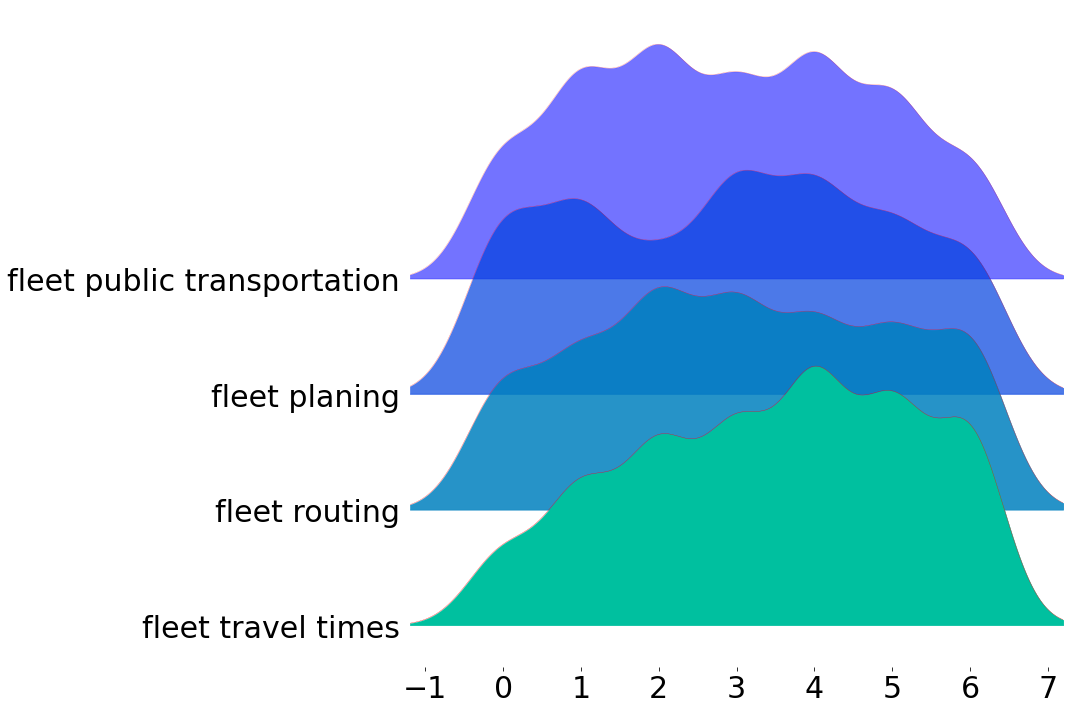

In [ ]:
import matplotlib as mpb
from matplotlib import cm

color_normal = mpb.colors.LinearSegmentedColormap.from_list('自定义的颜色名字',
                                                                          [
                                                                              (0, '#51689b'),
                                                                              (0, '#ce5c5c'),
                                                                              (1, '#fbc357')
                                                                          ], N=256)

fig, axes = joypy.joyplot(df,
                          # column=['lr'],
                          # column=['soc'],
                          # column=['lr', 'type'],

                          # column='type',
                          # column='ep',
                          # column='ep',

                          # by="type",
                          # by="soc",
                          # by=label,
                          # ylim='own',
                          linecolor="r",
                          # linecolor="w",
                          figsize=(15, 10),
                          xlabelsize=30,
                          ylabelsize=30,
                          fade=True,
                          # overlap=3, tails=20,
                          overlap=4,
                          tails=20,
                          # range_style='all',
                          fill=True, linewidth=0.3,
                          # fill=False, linewidth=1,
                          # hist=True,
                          # bins=20,
                          # colormap=plt.cm.Set1, )
                          colormap=cm.winter
                          # colormap=color_normal
                          # colormap= plt.get_cmap(ca_map[col])
                          )

fig.show()

##### 2.2.3 关键词-时间分布

[绘图](https://echarts.apache.org/examples/zh/editor.html?c=scatter-single-axis&code=PTAEAcCcFMBdYJbUgWgQcwHYHsYCgBjbTAZ1lAAtsBXSE0AXlAG09R3QByAJgAYBGXpwA0XPv34ixA7lJ4CAzHPEAWZQICs6_gDYRbDvP4B2bQA5tATnV8bk4QfbzusvAF0A3HhAQY8JKgYOPhEpOQAJgCGAJ70TMyckDSImOhy4AA2kZgIqenUAEYZCASgsJDZJOC4sJGIxHLlkQBu0BllCAC20CScnt5gUHCIyGhYuNADoKFkoFG1jCzMvKIroBpuosui_DubLGvcq_vboArHW2sqFweiGjenOg9rxs-iZm-glp-CP7ug3BOa34R1AKiBO3OoH4EOh12hsP49zOiKeYMRr1AOkRH3Rlx23zxtwBawUsO4_zJ-IBoMB1O4UI2W3-LxO_xZbNEoN4nLOD3-8J5zLu_NEaKFLH-mIlzH-uJl_0JCp2ayZkp2_zp6uhtN5_Ch2OFcNElj1yIkerRhu1JlExj1uLMesJIN5fDubv-atlXNB9qNDK5J25ey2oPZwa5D1BUJloMFkfW0bFydA0sT8sTSsTvxRYY1QfzOtDLHDUNNRf48KdlfNcZ2VpzmO94dxLYJHqL7rTiYponBXd1XahA5YsbtJyhlMnUdAMqhsZnYIejJXKbnS_TWyhuJh25Na-hqqXEn7J79J6no-YV8hJ_NWpvDZNJ-bJ7bJ5d865a2tT4BApLi4Z77gCU4nIKJbMPC05bPC3IQaIi5wf2DzwuaiFYmhdrYaAmYoV8hYsDBVyYaeRLQTsQ7EZCIE0caFEwea14wWiroEbaCIcY6ZGEt68GkphfY9gRwF5vRgYblsyKHCc5pQciCHSUhSFyahUksMiMlqVhGnMMiW6ae8RH6Qeel1nRpnQhGynFusOn6iqDnoQ5BkOWxe5GdCmJ_ua-FefwfE6d2VJecJ16KdRVmSTK4pQWxDxokpLBoshKXqbFIp6VaiU4dlxn5YRhW5p5zAebldmPmx4FbGx8KhWVOzItebHiicbGGY10L-V1gUVd2pVJZq7W-iZSUGm4_QzBEdSRIszCnKqAB0xgqBoZgKGYKjcJYxhmC4Ch7ngpxektGiWLwOhmLwe0XYIxgPUyx2HGKS3cBo-ofTo528GYu2WHSz0qViK2rVtKg6AovCWADvCA6c8LGEtJjfYFDK8OdOi8Ao_pA0mIPnZYGh8Bt3BmDoa0aAOeNokjlgKAoa0UzoLjvRtT2nJiSPGAyZMuCz_06Fdmx446S0Y39xiM2YUsgmTVJ44SZhLSoMsY7o63cA932GnjubK8Y0NQ2Te2Bb930iyd7L8MjIL6qtFIYzd3DUydoKWEtG2GyocMaMYLPGBoCgcyyJpnXtMvbVrDIUwIlvsmHgUKJDlgqPwkfQ7rPoAu8S2Q8nui8Jd63-4z8fA9z60y6tl1rWtGPl8ueHi39WMUu9ftmIFrtenaS2pwLKjBxoQcKJYG1Z_8tN51dWtD4IfsKAyPd5UjY-QxoEsbdvFON7iOig9DQ8fftqv7Qr2eEkjH03cTF1DwzKh7Y3uYHzoJhS6tq0qAPX0v6dxhx6_Tln9JEY8V52SRtjHQRMKaM0sOnMwGgLYOGYCGEGmhIb6h9r9bgOhVqW3DHcfuMD354OJnfNmhDZwHyrFtBBDJrr-yQfDGMr1A7k2TsYQQUdwbUKbgfJBLMdqGxlm3XQ_DkSCJgeTcGu1ArrSOmg9cSNq5Ex2kiLWe0f78MxMrPBY9g6BX2jzS6_CxYM39ujJEPMR4Q34UrPOLsRGXRZiCaGuNlFHkTi7BmJhx5IKMUo8M7JeBLSXuTKs9NVYMwujWY64ZQTK1Pg9H-3CGTByJpbccIMqwwKphDCQUMTAXynMQ1OfspbE22hDB68MoSgkEUPVawdMkU0DkohcfcXbaJxgolpqtsnqSgcTR-l0EGMxsUM_GB9RG-Nlj7Hat9pnTysV3ReRcg5k3if-LmntVpIjEcgvgY9PE7lzjdHGhsBCfXpig465Zc4Q2cZYdpXc0442mfrcJ6cf5EylgHLWXzQnI3WqnHmWNa4MyzlOd2KteAqFVuda5wCG5TWILMRAsAMjQHmuisIoASC5HQDigAggADwQHEFg-LZgkGQEgalzB-hRFiEtAAZrgAAopEAgFAAAU7LqCYAIPUTAoB-WstEAgcI5KACUoAADeBgsU4qWuAagJABXKo4GUaA5LYAACFIj0uKJgaAAAuLgnQZXhBxfoXVsBsDgCtfy_lMryWgAANRzjOgqgAVEeXgCqwDGG9VwAApA6jgsB9WwCtaygwABfOVXh2BEtSGSylJB1Wau1Y4UAOL2XxuhJvBwjrojgEtVwAgdRoDoFwNEaN7ACg0EwFESA0QADikQXWgHZZEDI9Ly0cHmJEK1VBaAkBHewJ1fb3WytAIGwQwbQChvDRocNnAo0zsoNADAFAS0rrXWmUAKAjxbp3QWyI2aAAykQChtCtTq3VoBcixsgM0QdVruAFqTcm1NBh6WQEZbmrV_KX3puJVmqlABJdt-qrUet3UQXA4Rch1oAMqxFjZ0K1nAM0kugBSqlzayiVurQR2t8BkBkbHVa5lu6SDRE6K2jImGEAAC9q1CpFWKiVY7YO4YVZBjgfhaDisE7h2Ubgl1gjTRwf97AU1eBU3gMdHLuW8oFbx0VCBiACdmkJ6AnQRNAYZT0ZgUmTPLEmktDTGrwNWaM9Jzy1nOhoMmoBtTzr-NMBfU67AGREB9tE9UIlYr8Nzs4Mmkdqrq3xZHYRmDJArXJeI9mpLFnUuEuy3gJNHggA)

In [ ]:
year_topic_dist = year_topic_distribution()
multi_word_topic_dist = keywords_topic_distribution(keywords_lst)
word_year_dist = np.dot(multi_word_topic_dist, year_topic_dist.T)
# t = word_year_dist / np.sum(word_year_dist, axis=1).reshape(-1, 1)
t = word_year_dist / np.sum(word_year_dist, axis=0)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
for i in range(t.shape[0]):
    for j in range(t.shape[1]):
        print(f"[{i}, {j}, {t[i][j]*100}],")

[0, 0, 5.314257539971097],
[0, 1, 6.806333329945458],
[0, 2, 8.202511927643116],
[0, 3, 7.663692467207501],
[0, 4, 8.803744145172741],
[0, 5, 8.365799806037728],
[0, 6, 8.463383325047097],
[0, 7, 7.612010883849312],
[0, 8, 7.741549752090196],
[0, 9, 7.474192584370337],
[0, 10, 8.648705065845542],
[0, 11, 8.807289363377905],
[0, 12, 6.096529809441975],
[1, 0, 5.807433282056131],
[1, 1, 6.707541594314832],
[1, 2, 7.3583686034362845],
[1, 3, 7.36350772392781],
[1, 4, 7.907327501236469],
[1, 5, 8.09863278350683],
[1, 6, 7.808906080896627],
[1, 7, 7.698002908147868],
[1, 8, 7.647486179244438],
[1, 9, 7.797447148877934],
[1, 10, 8.986699109175454],
[1, 11, 8.443221533744953],
[1, 12, 8.375425551434375],
[2, 0, 10.49454539737662],
[2, 1, 9.39226759739051],
[2, 2, 8.90416711636482],
[2, 3, 8.05949043254404],
[2, 4, 7.61838236163047],
[2, 5, 7.986925053369019],
[2, 6, 7.291581372569592],
[2, 7, 7.512154623369901],
[2, 8, 6.706312386560133],
[2, 9, 6.625955839278914],
[2, 10, 5.921626938851075],

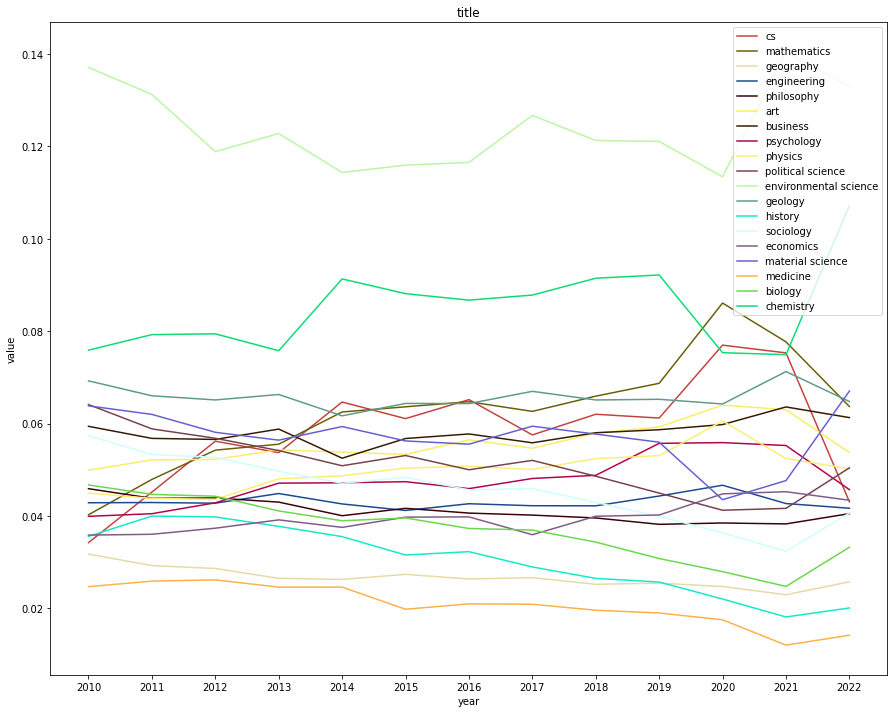

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

plt.rcParams["figure.figsize"] = (15, 12)

x = [
    '2010', '2011', '2012', '2013', '2014', '2015', '2016',
    '2017', '2018', '2019', '2020', '2021',
    '2022'
]

def sort_colors(colors=mcolors.XKCD_COLORS):  # 949
    by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                            for name, color in colors.items())
    cols = [name for hsv, name in by_hsv]
    cols = random.choices(cols, k=40)
    return cols
cols = sort_colors()
# cols = [color for name, color in mcolors.XKCD_COLORS.items()][200: 240]

for i in range(t.shape[0]):
    y = t[i]
    plt.plot(x, y, color=cols[i], label=keywords_lst[i])

plt.title('title')
plt.xlabel('year')
plt.ylabel('value')

plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

plt.show()